In [1]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from kerastuner.tuners import Hyperband

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


## Dataset Maker

In [2]:
case = 'demted'
flag = False
if case == 'demted':
    flag = True

In [3]:
if not flag:
    print('train dataset loaded')
    train_dataset = tf.data.Dataset.list_files('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented/*.jpg')

In [4]:
if flag:
    print('train dataset is loading')
    dirs = ['../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented']
    
    all_file_paths = []
    
    for cur_dir in dirs:
        file_names = os.listdir(cur_dir)
        file_paths = [os.path.join(cur_dir,file_name) for file_name in file_names]
        all_file_paths += file_paths
    print(f'total files {len(all_file_paths)}')
    train_dataset = tf.data.Dataset.from_tensor_slices(all_file_paths)
    print('train dataset loaded')

train dataset is loading
total files 2561


2022-12-16 11:20:47.009369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 11:20:47.118667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 11:20:47.119822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


train dataset loaded


2022-12-16 11:20:47.123050: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 11:20:47.123437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 11:20:47.124454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 11:20:47.125448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [5]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128,128])
    image /= 255.0  # normalize to [0,1] range
    return image
train_dataset = train_dataset.map(load_and_preprocess_image)
batch_size = 16
train_dataset = train_dataset.shuffle(10 * batch_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=50)

In [6]:
for idx,temp in enumerate(train_dataset):
    continue
steps_per_epoch = idx+1
standard = 100 * 160
epochs = standard // steps_per_epoch
steps_per_epoch, epochs

2022-12-16 11:20:49.957222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(160, 100)

In [7]:
from sklearn.utils import shuffle
for idx,temp in enumerate(train_dataset):
    
    if idx == 0:
        images  = np.copy(temp)
        continue
    images = np.concatenate((images,temp))
images = shuffle(images)
images = shuffle(images)

np.save('Dementia-alzheimer.npy',images)    

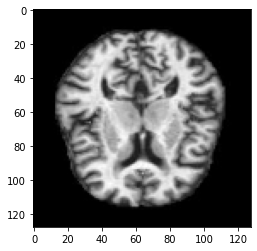

In [8]:
plt.imshow(temp[1],cmap='gray')

## Training

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [10]:
# data
num_epochs = 50  # train for 400 epochs for good results
image_size = 128
# resolution of Kernel Inception Distance measurement, see related section
kid_image_size = 75
padding = 0.25

# adaptive discriminator augmentation
max_translation = 0.125
max_rotation = 0.125
max_zoom = 0.25
target_accuracy = 0.85
integration_steps = 1000

# architecture
noise_size = 64
depth = 4
width = 128
leaky_relu_slope = 0.2
dropout_rate = 0.4

# optimization
batch_size = 16
learning_rate = 2e-4
beta_1 = 0.5  # not using the default value of 0.9 is important
ema = 0.99

In [11]:
def round_to_int(float_value):
    return tf.cast(tf.math.round(float_value), dtype=tf.int32)

class KID(keras.metrics.Metric):
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3)
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


In [12]:
# "hard sigmoid", useful for binary accuracy calculation from logits
def step(values):
    # negative values -> 0.0, positive values -> 1.0
    return 0.5 * (1.0 + tf.sign(values))


# augments images with a probability that is dynamically updated during training
class AdaptiveAugmenter(keras.Model):
    def __init__(self):
        super().__init__()

        # stores the current probability of an image being augmented
        self.probability = tf.Variable(0.0)

        # the corresponding augmentation names from the paper are shown above each layer
        # the authors show (see figure 4), that the blitting and geometric augmentations
        # are the most helpful in the low-data regime
        self.augmenter = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                # blitting/x-flip:
                layers.RandomFlip("horizontal"),
                # blitting/integer translation:
                layers.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                layers.RandomRotation(factor=max_rotation),
                # geometric/isotropic and anisotropic scaling:
                layers.RandomZoom(
                    height_factor=(-max_zoom, 0.0), width_factor=(-max_zoom, 0.0)
                ),
            ],
            name="adaptive_augmenter",
        )

    def call(self, images, training):
        if training:
            augmented_images = self.augmenter(images, training)

            # during training either the original or the augmented images are selected
            # based on self.probability
            augmentation_values = tf.random.uniform(
                shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
            )
            augmentation_bools = tf.math.less(augmentation_values, self.probability)

            images = tf.where(augmentation_bools, augmented_images, images)
        return images

    def update(self, real_logits):
        current_accuracy = tf.reduce_mean(step(real_logits))

        # the augmentation probability is updated based on the dicriminator's
        # accuracy on real images
        accuracy_error = current_accuracy - target_accuracy
        self.probability.assign(
            tf.clip_by_value(
                self.probability + accuracy_error / integration_steps, 0.0, 1.0
            )
        )


In [13]:
# DCGAN generator
def get_generator():
    noise_input = keras.Input(shape=(noise_size,))
    x = layers.Dense(4 * 4 * width, use_bias=False)(noise_input)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)
    x = layers.Reshape(target_shape=(4, 4, width))(x)
    for _ in range(depth):
        x = layers.Conv2DTranspose(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.ReLU()(x)
    image_output = layers.Conv2DTranspose(
        1, kernel_size=4, strides=2, padding="same", activation="sigmoid",
    )(x)

    return keras.Model(noise_input, image_output, name="generator")


# DCGAN discriminator
def get_discriminator():
    image_input = keras.Input(shape=(image_size, image_size, 1))
    x = image_input
    for _ in range(depth):
        x = layers.Conv2D(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.LeakyReLU(alpha=leaky_relu_slope)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_score = layers.Dense(1)(x)

    return keras.Model(image_input, output_score, name="discriminator")


In [14]:

class GAN_ADA(keras.Model):
    def __init__(self):
        super().__init__()

        self.augmenter = AdaptiveAugmenter()
        self.generator = get_generator()
        self.ema_generator = keras.models.clone_model(self.generator)
        self.discriminator = get_discriminator()

        self.generator.summary()
        self.discriminator.summary()

    def compile(self, generator_optimizer, discriminator_optimizer, **kwargs):
        super().compile(**kwargs)

        # separate optimizers for the two networks
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.generator_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.discriminator_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.real_accuracy = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_accuracy = keras.metrics.BinaryAccuracy(name="gen_acc")
        self.augmentation_probability_tracker = keras.metrics.Mean(name="aug_p")
        self.kid = KID()

    @property
    def metrics(self):
        return [
            self.generator_loss_tracker,
            self.discriminator_loss_tracker,
            self.real_accuracy,
            self.generated_accuracy,
            self.augmentation_probability_tracker,
            self.kid,
        ]

    def generate(self, batch_size, training):
        latent_samples = tf.random.normal(shape=(batch_size, noise_size))
        # use ema_generator during inference
        if training:
            generated_images = self.generator(latent_samples, training)
        else:
            generated_images = self.ema_generator(latent_samples, training)
        return generated_images

    def adversarial_loss(self, real_logits, generated_logits):
        # this is usually called the non-saturating GAN loss

        real_labels = tf.ones(shape=(batch_size, 1))
        generated_labels = tf.zeros(shape=(batch_size, 1))

        # the generator tries to produce images that the discriminator considers as real
        generator_loss = keras.losses.binary_crossentropy(
            real_labels, generated_logits, from_logits=True
        )
        # the discriminator tries to determine if images are real or generated
        discriminator_loss = keras.losses.binary_crossentropy(
            tf.concat([real_labels, generated_labels], axis=0),
            tf.concat([real_logits, generated_logits], axis=0),
            from_logits=True,
        )

        return tf.reduce_mean(generator_loss), tf.reduce_mean(discriminator_loss)

    def train_step(self, real_images):
        real_images = self.augmenter(real_images, training=True)

        # use persistent gradient tape because gradients will be calculated twice
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generate(batch_size, training=True)
            # gradient is calculated through the image augmentation
            generated_images = self.augmenter(generated_images, training=True)

            # separate forward passes for the real and generated images, meaning
            # that batch normalization is applied separately
            real_logits = self.discriminator(real_images, training=True)
            generated_logits = self.discriminator(generated_images, training=True)

            generator_loss, discriminator_loss = self.adversarial_loss(
                real_logits, generated_logits
            )

        # calculate gradients and update weights
        generator_gradients = tape.gradient(
            generator_loss, self.generator.trainable_weights
        )
        discriminator_gradients = tape.gradient(
            discriminator_loss, self.discriminator.trainable_weights
        )
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_weights)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_weights)
        )

        # update the augmentation probability based on the discriminator's performance
        self.augmenter.update(real_logits)

        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)
        self.real_accuracy.update_state(1.0, step(real_logits))
        self.generated_accuracy.update_state(0.0, step(generated_logits))
        self.augmentation_probability_tracker.update_state(self.augmenter.probability)

        # track the exponential moving average of the generator's weights to decrease
        # variance in the generation quality
        for weight, ema_weight in zip(
            self.generator.weights, self.ema_generator.weights
        ):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, real_images):
        generated_images = self.generate(batch_size, training=False)

        self.kid.update_state(real_images, generated_images)

        # only KID is measured during the evaluation phase for computational efficiency
        return {self.kid.name: self.kid.result()}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6, interval=5):
        # plot random generated images for visual evaluation of generation quality
        if epoch is None or (epoch + 1) % interval == 0:
            num_images = num_rows * num_cols
            generated_images = self.generate(num_images, training=False)

            plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
            for row in range(num_rows):
                for col in range(num_cols):
                    index = row * num_cols + col
                    plt.subplot(num_rows, num_cols, index + 1)
                    plt.imshow(generated_images[index],cmap='gray')
                    plt.axis("off")
            plt.tight_layout()
            plt.show()
            plt.savefig('out.png',dpi=300)
            plt.close()


In [15]:
# create and compile the model
model = GAN_ADA()
model.compile(
    generator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
    discriminator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
)

# save the best model based on the validation KID metric
checkpoint_path = "gan_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              131072    
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              6144      
_________________________________________________________________
re_lu (ReLU)                 (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         262144    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         38

Epoch 1/100


2022-12-16 11:21:08.430534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Invalid argument: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/adaptive_augmenter/SelectV2_1-1-TransposeNHWCToNCHW-LayoutOptimizer
2022-12-16 11:21:09.055611: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x557ead004260
2022-12-16 11:21:12.845715: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


160/160 [==============================] - 20s 46ms/step - g_loss: 4.3827 - d_loss: 0.1101 - real_acc: 0.9781 - gen_acc: 0.9848 - aug_p: 0.0110
Epoch 2/100
160/160 [==============================] - 8s 47ms/step - g_loss: 4.6946 - d_loss: 0.1190 - real_acc: 0.9551 - gen_acc: 0.9754 - aug_p: 0.0309
Epoch 3/100
160/160 [==============================] - 7s 46ms/step - g_loss: 2.6221 - d_loss: 0.3695 - real_acc: 0.8363 - gen_acc: 0.8562 - aug_p: 0.0374
Epoch 4/100
160/160 [==============================] - 7s 46ms/step - g_loss: 2.5926 - d_loss: 0.3236 - real_acc: 0.8660 - gen_acc: 0.8660 - aug_p: 0.0377
Epoch 5/100
160/160 [==============================] - 7s 46ms/step - g_loss: 2.5967 - d_loss: 0.3583 - real_acc: 0.8543 - gen_acc: 0.8508 - aug_p: 0.0388


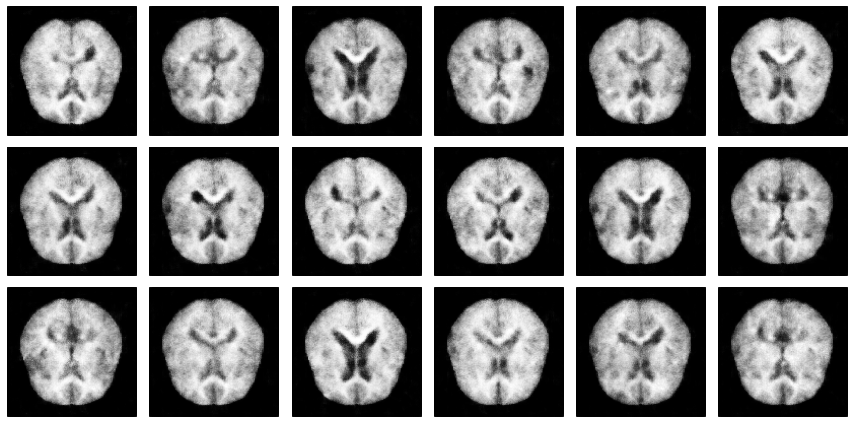

Epoch 6/100
160/160 [==============================] - 7s 46ms/step - g_loss: 2.3807 - d_loss: 0.3813 - real_acc: 0.8289 - gen_acc: 0.8363 - aug_p: 0.0377
Epoch 7/100
160/160 [==============================] - 8s 46ms/step - g_loss: 2.2848 - d_loss: 0.3883 - real_acc: 0.8277 - gen_acc: 0.8371 - aug_p: 0.0339
Epoch 8/100
160/160 [==============================] - 8s 47ms/step - g_loss: 2.1777 - d_loss: 0.3912 - real_acc: 0.8184 - gen_acc: 0.8359 - aug_p: 0.0296
Epoch 9/100
160/160 [==============================] - 8s 47ms/step - g_loss: 2.2275 - d_loss: 0.3899 - real_acc: 0.8195 - gen_acc: 0.8199 - aug_p: 0.0246
Epoch 10/100
160/160 [==============================] - 8s 47ms/step - g_loss: 2.1576 - d_loss: 0.4038 - real_acc: 0.8098 - gen_acc: 0.8180 - aug_p: 0.0191


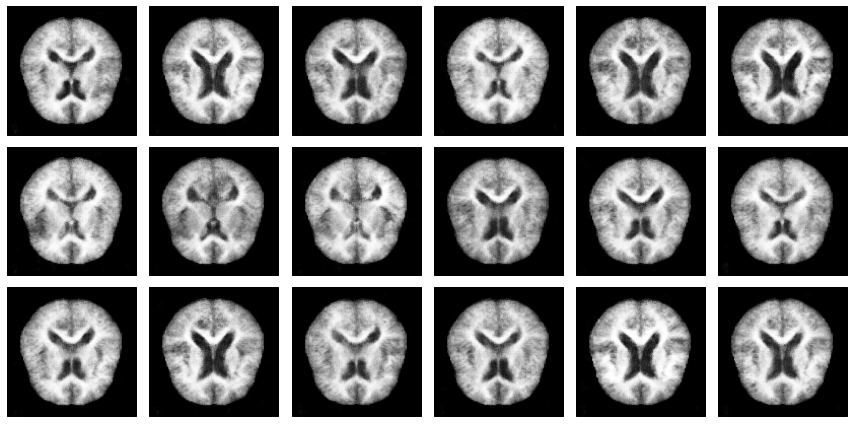

Epoch 11/100
160/160 [==============================] - 7s 46ms/step - g_loss: 2.0561 - d_loss: 0.3924 - real_acc: 0.8184 - gen_acc: 0.8406 - aug_p: 0.0129
Epoch 12/100
160/160 [==============================] - 7s 46ms/step - g_loss: 2.0728 - d_loss: 0.4298 - real_acc: 0.7984 - gen_acc: 0.8047 - aug_p: 0.0069
Epoch 13/100
160/160 [==============================] - 8s 48ms/step - g_loss: 2.0216 - d_loss: 0.4276 - real_acc: 0.8000 - gen_acc: 0.8023 - aug_p: 5.9458e-04
Epoch 14/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.9350 - d_loss: 0.4189 - real_acc: 0.8066 - gen_acc: 0.8164 - aug_p: 1.3828e-04
Epoch 15/100
160/160 [==============================] - 7s 46ms/step - g_loss: 2.0687 - d_loss: 0.4469 - real_acc: 0.7852 - gen_acc: 0.7973 - aug_p: 1.1102e-04


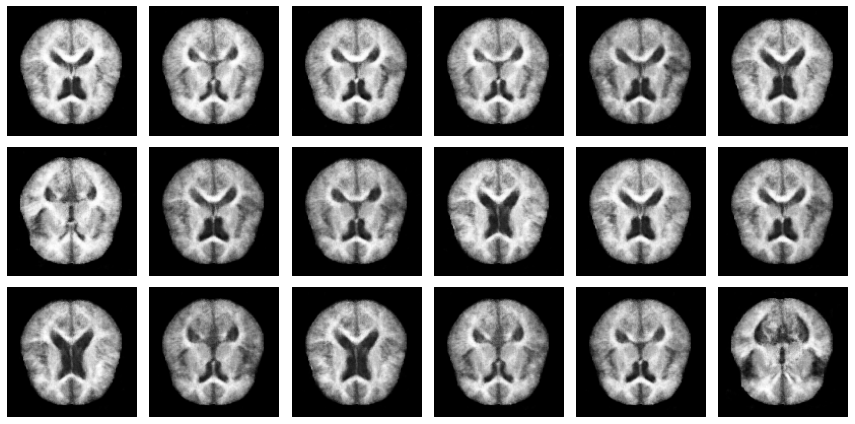

Epoch 16/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.8540 - d_loss: 0.4541 - real_acc: 0.7828 - gen_acc: 0.7910 - aug_p: 8.2734e-05
Epoch 17/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.8433 - d_loss: 0.4707 - real_acc: 0.7789 - gen_acc: 0.7809 - aug_p: 8.0391e-05
Epoch 18/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6888 - d_loss: 0.4695 - real_acc: 0.7680 - gen_acc: 0.7836 - aug_p: 6.2266e-05
Epoch 19/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.7636 - d_loss: 0.4750 - real_acc: 0.7578 - gen_acc: 0.7762 - aug_p: 4.9219e-05
Epoch 20/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.7454 - d_loss: 0.4736 - real_acc: 0.7629 - gen_acc: 0.7859 - aug_p: 5.1094e-05


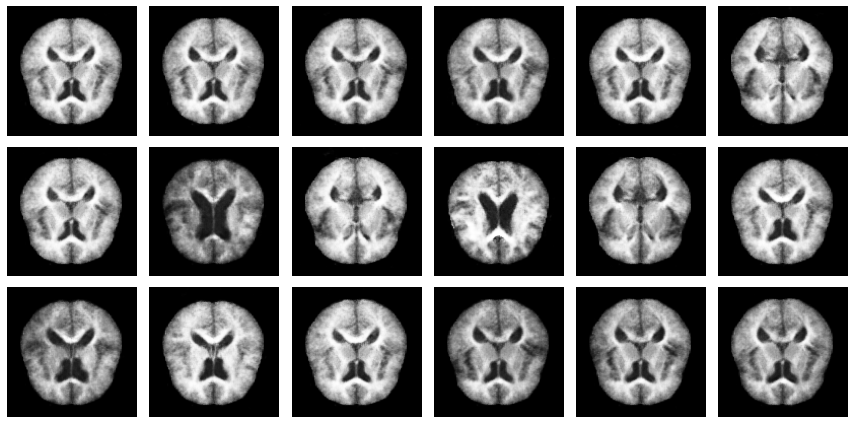

Epoch 21/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.7061 - d_loss: 0.4821 - real_acc: 0.7621 - gen_acc: 0.7781 - aug_p: 5.3828e-05
Epoch 22/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.7573 - d_loss: 0.4981 - real_acc: 0.7523 - gen_acc: 0.7801 - aug_p: 6.0859e-05
Epoch 23/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.6840 - d_loss: 0.4758 - real_acc: 0.7586 - gen_acc: 0.7789 - aug_p: 4.8359e-05
Epoch 24/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.7285 - d_loss: 0.4748 - real_acc: 0.7594 - gen_acc: 0.7863 - aug_p: 5.9844e-05
Epoch 25/100
160/160 [==============================] - 7s 45ms/step - g_loss: 1.6720 - d_loss: 0.4843 - real_acc: 0.7563 - gen_acc: 0.7785 - aug_p: 4.3906e-05


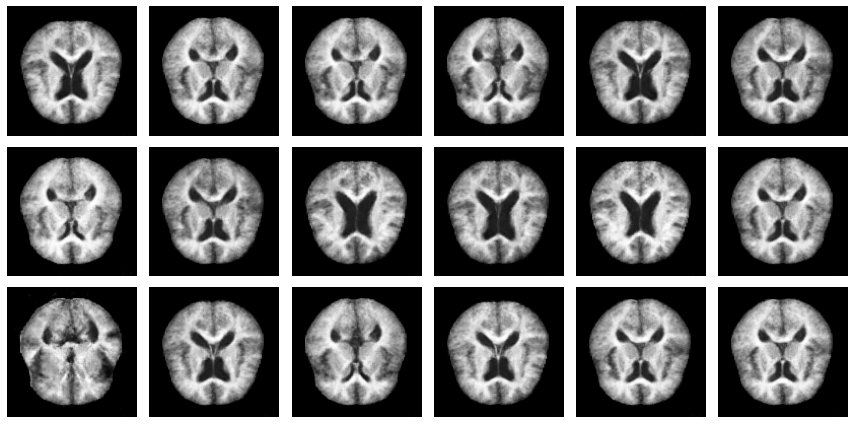

Epoch 26/100
160/160 [==============================] - 8s 46ms/step - g_loss: 1.6599 - d_loss: 0.5040 - real_acc: 0.7477 - gen_acc: 0.7563 - aug_p: 4.1016e-05
Epoch 27/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6159 - d_loss: 0.5029 - real_acc: 0.7406 - gen_acc: 0.7695 - aug_p: 3.2578e-05
Epoch 28/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6285 - d_loss: 0.4909 - real_acc: 0.7508 - gen_acc: 0.7563 - aug_p: 3.4141e-05
Epoch 29/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6277 - d_loss: 0.5015 - real_acc: 0.7488 - gen_acc: 0.7594 - aug_p: 4.5547e-05
Epoch 30/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.5696 - d_loss: 0.5205 - real_acc: 0.7293 - gen_acc: 0.7582 - aug_p: 3.5703e-05


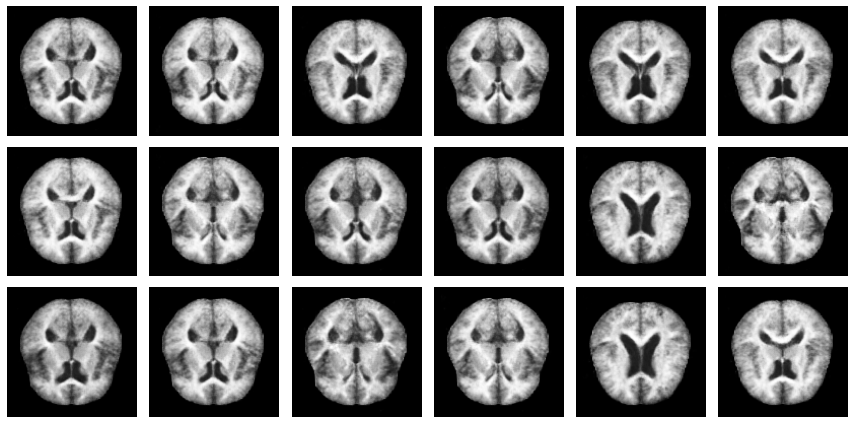

Epoch 31/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6113 - d_loss: 0.5200 - real_acc: 0.7414 - gen_acc: 0.7527 - aug_p: 3.8281e-05
Epoch 32/100
160/160 [==============================] - 7s 45ms/step - g_loss: 1.5642 - d_loss: 0.5205 - real_acc: 0.7352 - gen_acc: 0.7574 - aug_p: 3.6484e-05
Epoch 33/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6355 - d_loss: 0.4828 - real_acc: 0.7465 - gen_acc: 0.7785 - aug_p: 4.0859e-05
Epoch 34/100
160/160 [==============================] - 8s 46ms/step - g_loss: 1.5601 - d_loss: 0.5146 - real_acc: 0.7320 - gen_acc: 0.7621 - aug_p: 3.5469e-05
Epoch 35/100
160/160 [==============================] - 8s 46ms/step - g_loss: 1.5704 - d_loss: 0.5350 - real_acc: 0.7309 - gen_acc: 0.7500 - aug_p: 3.0312e-05


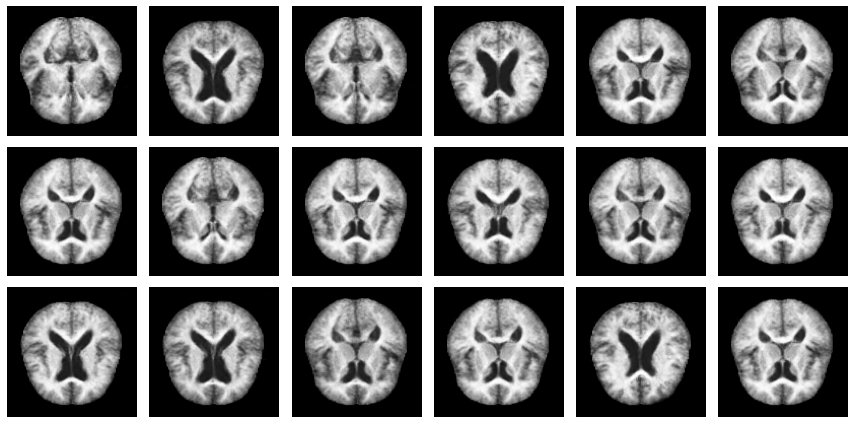

Epoch 36/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.6642 - d_loss: 0.5108 - real_acc: 0.7434 - gen_acc: 0.7574 - aug_p: 4.4375e-05
Epoch 37/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.5205 - d_loss: 0.5141 - real_acc: 0.7289 - gen_acc: 0.7695 - aug_p: 3.7734e-05
Epoch 38/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.5175 - d_loss: 0.5219 - real_acc: 0.7348 - gen_acc: 0.7578 - aug_p: 3.6562e-05
Epoch 39/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.5733 - d_loss: 0.5191 - real_acc: 0.7383 - gen_acc: 0.7652 - aug_p: 3.4687e-05
Epoch 40/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.5231 - d_loss: 0.5263 - real_acc: 0.7320 - gen_acc: 0.7516 - aug_p: 3.4531e-05


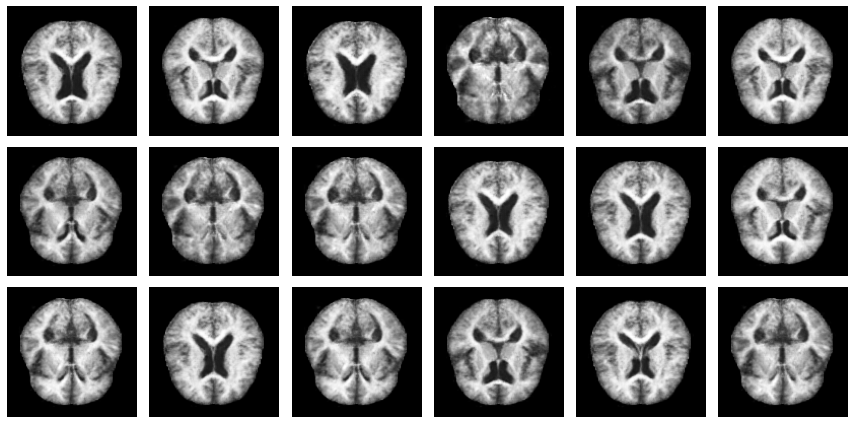

Epoch 41/100
160/160 [==============================] - 7s 45ms/step - g_loss: 1.5503 - d_loss: 0.4933 - real_acc: 0.7469 - gen_acc: 0.7766 - aug_p: 3.9219e-05
Epoch 42/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6498 - d_loss: 0.4755 - real_acc: 0.7547 - gen_acc: 0.7828 - aug_p: 4.0000e-05
Epoch 43/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.5692 - d_loss: 0.5176 - real_acc: 0.7348 - gen_acc: 0.7598 - aug_p: 3.8203e-05
Epoch 44/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.5172 - d_loss: 0.5151 - real_acc: 0.7367 - gen_acc: 0.7680 - aug_p: 4.0312e-05
Epoch 45/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.5404 - d_loss: 0.5048 - real_acc: 0.7359 - gen_acc: 0.7574 - aug_p: 3.5078e-05


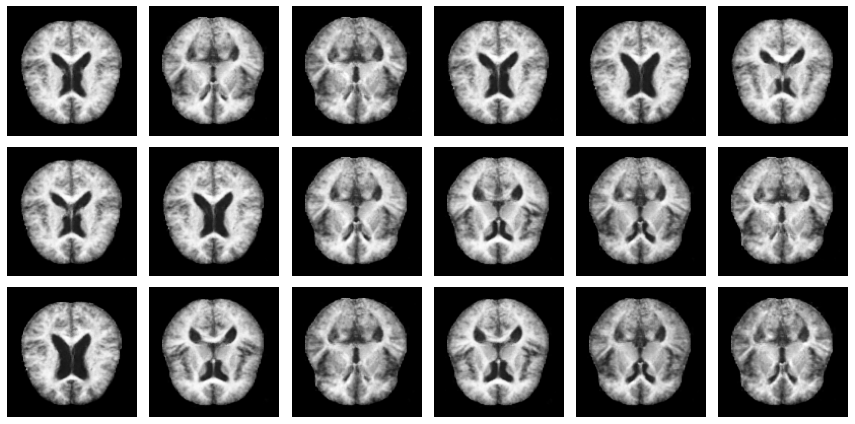

Epoch 46/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6011 - d_loss: 0.5036 - real_acc: 0.7418 - gen_acc: 0.7711 - aug_p: 4.0859e-05
Epoch 47/100
160/160 [==============================] - 7s 45ms/step - g_loss: 1.5956 - d_loss: 0.4901 - real_acc: 0.7453 - gen_acc: 0.7770 - aug_p: 3.5937e-05
Epoch 48/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6294 - d_loss: 0.4748 - real_acc: 0.7547 - gen_acc: 0.7793 - aug_p: 6.9141e-05
Epoch 49/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6581 - d_loss: 0.4743 - real_acc: 0.7598 - gen_acc: 0.7883 - aug_p: 6.2187e-05
Epoch 50/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.6363 - d_loss: 0.4614 - real_acc: 0.7609 - gen_acc: 0.7953 - aug_p: 6.2109e-05


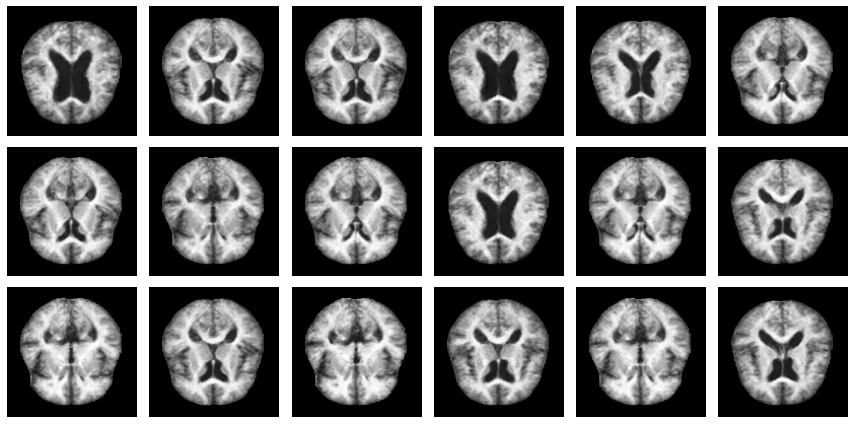

Epoch 51/100
160/160 [==============================] - 7s 45ms/step - g_loss: 1.6255 - d_loss: 0.4815 - real_acc: 0.7645 - gen_acc: 0.7898 - aug_p: 3.9531e-05
Epoch 52/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6994 - d_loss: 0.4797 - real_acc: 0.7473 - gen_acc: 0.8055 - aug_p: 4.0078e-05
Epoch 53/100
160/160 [==============================] - 8s 46ms/step - g_loss: 1.8123 - d_loss: 0.4422 - real_acc: 0.7848 - gen_acc: 0.8082 - aug_p: 8.0781e-05
Epoch 54/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6955 - d_loss: 0.4588 - real_acc: 0.7676 - gen_acc: 0.8043 - aug_p: 5.1094e-05
Epoch 55/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6991 - d_loss: 0.4619 - real_acc: 0.7750 - gen_acc: 0.8023 - aug_p: 6.1484e-05


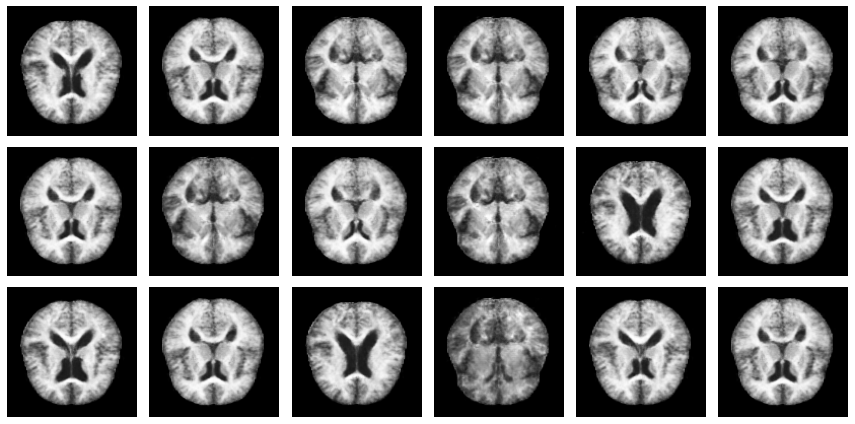

Epoch 56/100
160/160 [==============================] - 7s 45ms/step - g_loss: 1.6356 - d_loss: 0.4876 - real_acc: 0.7465 - gen_acc: 0.7801 - aug_p: 5.6172e-05
Epoch 57/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.6374 - d_loss: 0.4847 - real_acc: 0.7512 - gen_acc: 0.7805 - aug_p: 4.1484e-05
Epoch 58/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6494 - d_loss: 0.4744 - real_acc: 0.7586 - gen_acc: 0.7816 - aug_p: 4.8203e-05
Epoch 59/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.6741 - d_loss: 0.4709 - real_acc: 0.7586 - gen_acc: 0.7871 - aug_p: 5.4062e-05
Epoch 60/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.7790 - d_loss: 0.4638 - real_acc: 0.7723 - gen_acc: 0.7945 - aug_p: 5.7266e-05


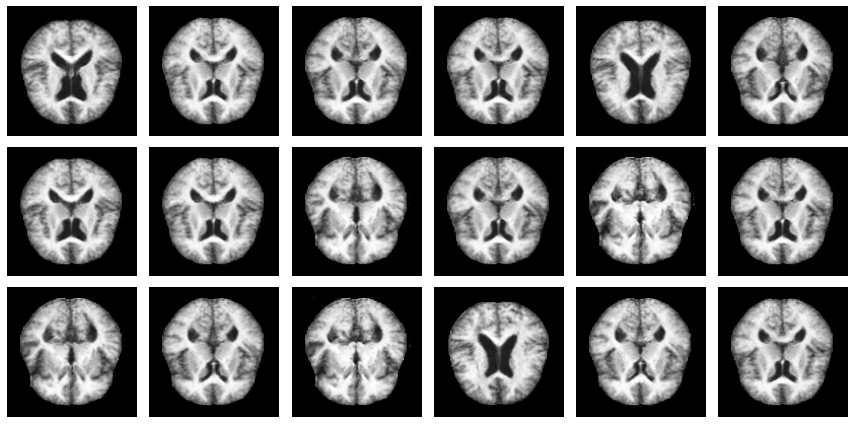

Epoch 61/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.6503 - d_loss: 0.4899 - real_acc: 0.7578 - gen_acc: 0.7766 - aug_p: 6.1484e-05
Epoch 62/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.6122 - d_loss: 0.4866 - real_acc: 0.7516 - gen_acc: 0.7797 - aug_p: 3.6875e-05
Epoch 63/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.7817 - d_loss: 0.4243 - real_acc: 0.7902 - gen_acc: 0.8113 - aug_p: 6.8125e-05
Epoch 64/100
160/160 [==============================] - 8s 48ms/step - g_loss: 1.7590 - d_loss: 0.4313 - real_acc: 0.7840 - gen_acc: 0.8223 - aug_p: 7.9375e-05
Epoch 65/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.8325 - d_loss: 0.4588 - real_acc: 0.7719 - gen_acc: 0.7844 - aug_p: 8.5859e-05


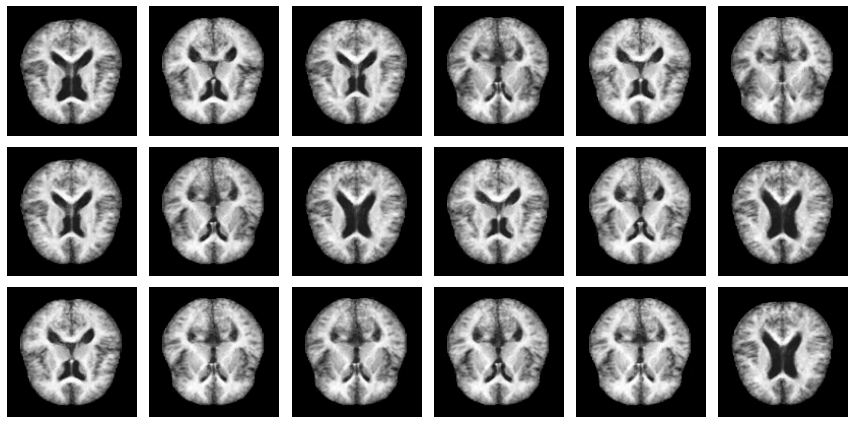

Epoch 66/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.6945 - d_loss: 0.4601 - real_acc: 0.7691 - gen_acc: 0.7969 - aug_p: 6.3437e-05
Epoch 67/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.8844 - d_loss: 0.3878 - real_acc: 0.8129 - gen_acc: 0.8480 - aug_p: 1.3648e-04
Epoch 68/100
160/160 [==============================] - 8s 48ms/step - g_loss: 1.7770 - d_loss: 0.4677 - real_acc: 0.7633 - gen_acc: 0.7953 - aug_p: 4.8594e-05
Epoch 69/100
160/160 [==============================] - 8s 48ms/step - g_loss: 1.7041 - d_loss: 0.4623 - real_acc: 0.7648 - gen_acc: 0.7953 - aug_p: 6.3750e-05
Epoch 70/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.8726 - d_loss: 0.4352 - real_acc: 0.7867 - gen_acc: 0.8086 - aug_p: 6.0547e-05


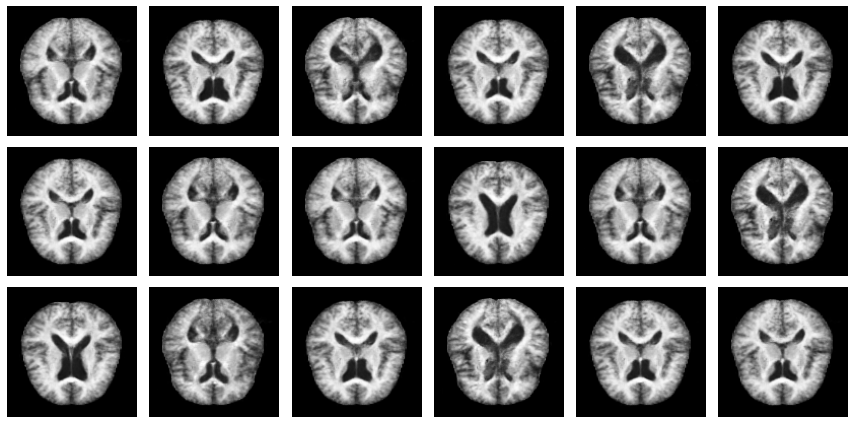

Epoch 71/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.7737 - d_loss: 0.4385 - real_acc: 0.7723 - gen_acc: 0.8109 - aug_p: 6.9922e-05
Epoch 72/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.8449 - d_loss: 0.4385 - real_acc: 0.7820 - gen_acc: 0.8137 - aug_p: 7.6328e-05
Epoch 73/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.8138 - d_loss: 0.4016 - real_acc: 0.8012 - gen_acc: 0.8293 - aug_p: 1.5250e-04
Epoch 74/100
160/160 [==============================] - 8s 48ms/step - g_loss: 1.9165 - d_loss: 0.4099 - real_acc: 0.7945 - gen_acc: 0.8305 - aug_p: 9.5156e-05
Epoch 75/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.8594 - d_loss: 0.4552 - real_acc: 0.7738 - gen_acc: 0.7965 - aug_p: 6.0547e-05


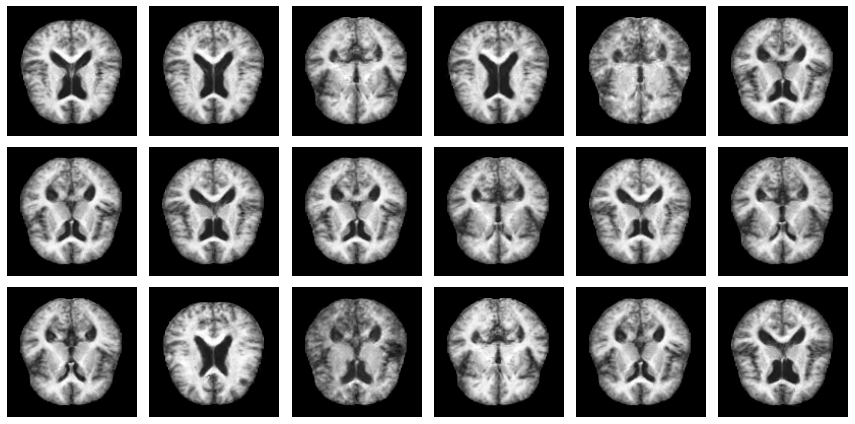

Epoch 76/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.8542 - d_loss: 0.4248 - real_acc: 0.7945 - gen_acc: 0.8160 - aug_p: 1.0437e-04
Epoch 77/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.9674 - d_loss: 0.4157 - real_acc: 0.8027 - gen_acc: 0.8238 - aug_p: 1.0617e-04
Epoch 78/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.9381 - d_loss: 0.3941 - real_acc: 0.8098 - gen_acc: 0.8391 - aug_p: 1.2094e-04
Epoch 79/100
160/160 [==============================] - 8s 47ms/step - g_loss: 2.0719 - d_loss: 0.3845 - real_acc: 0.8168 - gen_acc: 0.8441 - aug_p: 1.8594e-04
Epoch 80/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.9616 - d_loss: 0.3887 - real_acc: 0.8105 - gen_acc: 0.8445 - aug_p: 1.0250e-04


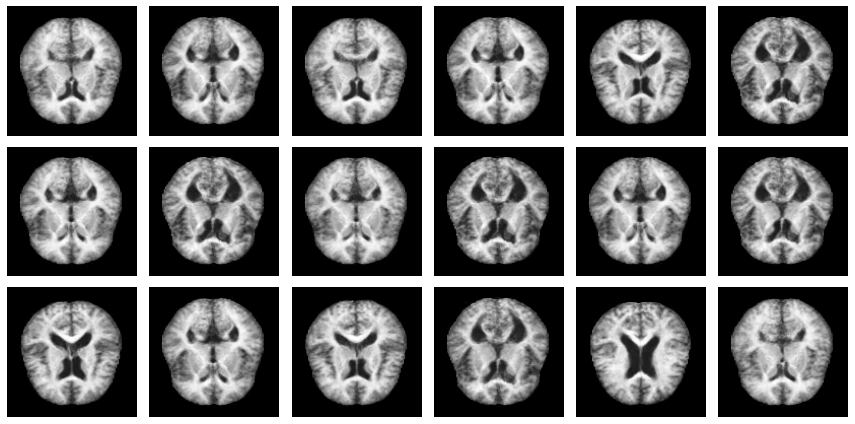

Epoch 81/100
160/160 [==============================] - 8s 49ms/step - g_loss: 2.0067 - d_loss: 0.4136 - real_acc: 0.8008 - gen_acc: 0.8191 - aug_p: 8.9141e-05
Epoch 82/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.8559 - d_loss: 0.4399 - real_acc: 0.7750 - gen_acc: 0.8066 - aug_p: 5.4922e-05
Epoch 83/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.9582 - d_loss: 0.4178 - real_acc: 0.7914 - gen_acc: 0.8258 - aug_p: 1.0031e-04
Epoch 84/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.9359 - d_loss: 0.4171 - real_acc: 0.7988 - gen_acc: 0.8109 - aug_p: 1.0180e-04
Epoch 85/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.9754 - d_loss: 0.4210 - real_acc: 0.8008 - gen_acc: 0.8160 - aug_p: 1.0500e-04


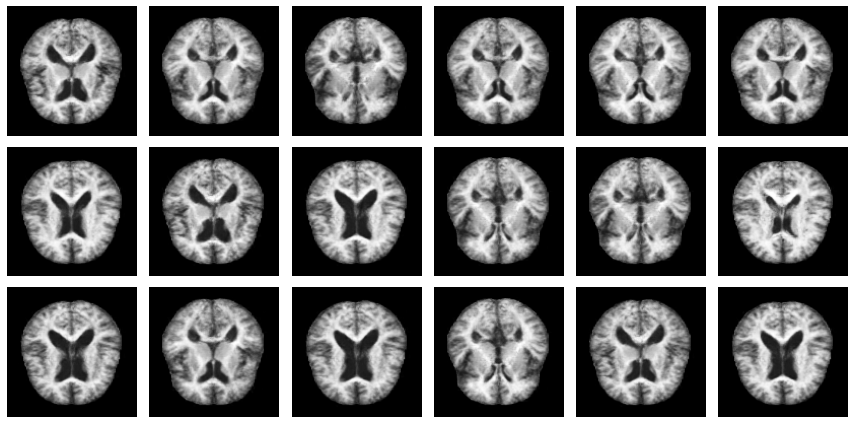

Epoch 86/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.9065 - d_loss: 0.4416 - real_acc: 0.7941 - gen_acc: 0.8066 - aug_p: 1.0914e-04
Epoch 87/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.9492 - d_loss: 0.4138 - real_acc: 0.7973 - gen_acc: 0.8176 - aug_p: 8.5859e-05
Epoch 88/100
160/160 [==============================] - 8s 49ms/step - g_loss: 1.9990 - d_loss: 0.4313 - real_acc: 0.7973 - gen_acc: 0.8094 - aug_p: 9.3984e-05
Epoch 89/100
160/160 [==============================] - 8s 47ms/step - g_loss: 1.9034 - d_loss: 0.4314 - real_acc: 0.7871 - gen_acc: 0.8203 - aug_p: 9.4922e-05
Epoch 90/100
160/160 [==============================] - 8s 47ms/step - g_loss: 2.0192 - d_loss: 0.3765 - real_acc: 0.8250 - gen_acc: 0.8613 - aug_p: 2.0047e-04


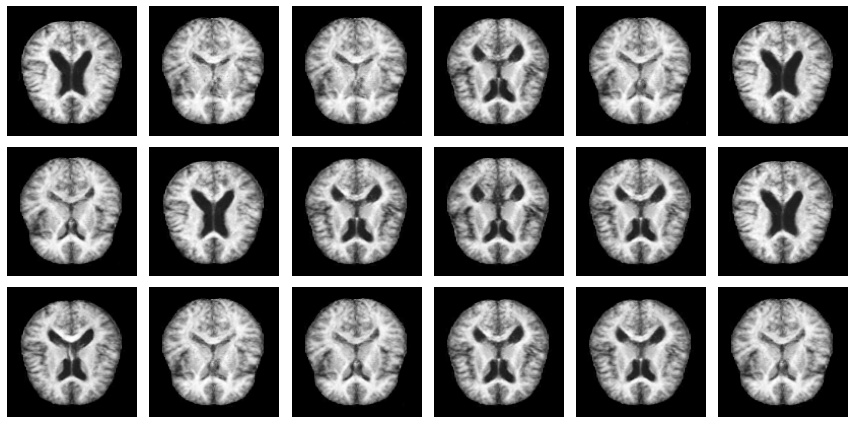

Epoch 91/100
160/160 [==============================] - 8s 47ms/step - g_loss: 2.1125 - d_loss: 0.3478 - real_acc: 0.8422 - gen_acc: 0.8625 - aug_p: 4.7187e-04
Epoch 92/100
160/160 [==============================] - 8s 48ms/step - g_loss: 1.9849 - d_loss: 0.4211 - real_acc: 0.7937 - gen_acc: 0.8188 - aug_p: 1.0242e-04
Epoch 93/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.9207 - d_loss: 0.4134 - real_acc: 0.7918 - gen_acc: 0.8230 - aug_p: 9.2500e-05
Epoch 94/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.8789 - d_loss: 0.4693 - real_acc: 0.7691 - gen_acc: 0.7906 - aug_p: 5.2187e-05
Epoch 95/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.8118 - d_loss: 0.4578 - real_acc: 0.7707 - gen_acc: 0.7941 - aug_p: 8.2812e-05


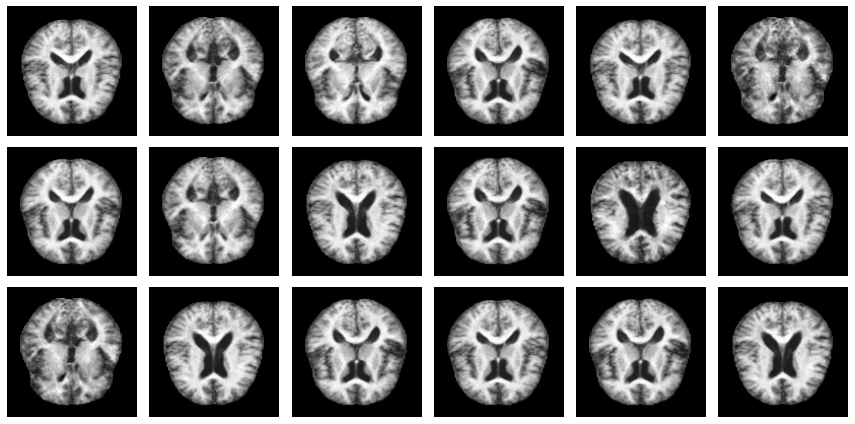

Epoch 96/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.8795 - d_loss: 0.4504 - real_acc: 0.7789 - gen_acc: 0.8074 - aug_p: 7.4219e-05
Epoch 97/100
160/160 [==============================] - 7s 46ms/step - g_loss: 1.9083 - d_loss: 0.4313 - real_acc: 0.7840 - gen_acc: 0.8203 - aug_p: 8.1641e-05
Epoch 98/100
160/160 [==============================] - 8s 46ms/step - g_loss: 1.9934 - d_loss: 0.4009 - real_acc: 0.8102 - gen_acc: 0.8359 - aug_p: 1.2547e-04
Epoch 99/100
160/160 [==============================] - 7s 46ms/step - g_loss: 2.1428 - d_loss: 0.3932 - real_acc: 0.8141 - gen_acc: 0.8289 - aug_p: 1.5070e-04
Epoch 100/100
160/160 [==============================] - 7s 46ms/step - g_loss: 2.0174 - d_loss: 0.4009 - real_acc: 0.8070 - gen_acc: 0.8262 - aug_p: 9.2734e-05


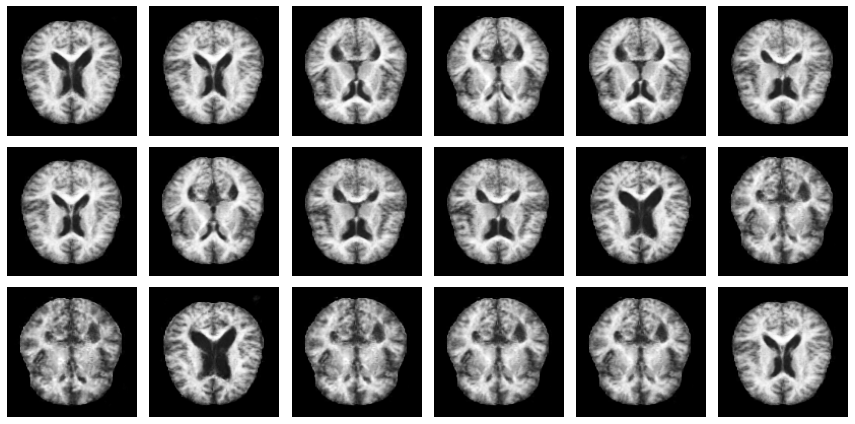

In [16]:
# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=100,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

## fine tune on ppmi

In [17]:
model.generator.save_weights('gen.h5')
model.ema_generator.save_weights('ema_gen.h5')
model.discriminator.save_weights('disc.h5')

In [18]:
images = np.load('/kaggle/input/ppmi-numpy-files/PD-TRAIN-IMAGES.npy')

images = np.concatenate((images,images,images,images,images),axis=0)
from sklearn.utils import shuffle

images = shuffle(images)
images = shuffle(images)
images.shape

(4000, 128, 128, 1)

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices(images)

In [20]:
batch_size = 32
train_dataset = train_dataset.shuffle(10 * batch_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=50)

In [21]:
for idx,temp in enumerate(train_dataset):
    continue
steps_per_epoch = idx+1
standard = 50 * 160
epochs = standard // steps_per_epoch
steps_per_epoch, standard, temp.shape

(125, 8000, TensorShape([32, 128, 128, 1]))

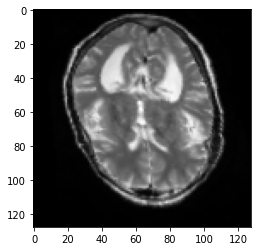

In [22]:
plt.imshow(temp[0],cmap='gray')

In [ ]:
# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=200,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

In [24]:
generated_images = model.generate(1000,False)
np.save('GAN2-FT-PD.npy',generated_images)

## Classification with Original Images

In [ ]:
import shutil

In [ ]:
dir_path = '/kaggle/working/data'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [ ]:
dirs = ['/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented']
all_file_paths = []
    
for cur_dir in dirs:
    file_names = os.listdir(cur_dir)
    file_paths = [os.path.join(cur_dir,file_name) for file_name in file_names]
    all_file_paths += file_paths

folder_path = os.path.join(dir_path,'Non-Dementia')

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
else:
    shutil.rmtree(folder_path)
    os.makedirs(folder_path)

counter_non_dementia = 0
name = "image"
for file_path in all_file_paths:
    dest_name = name + "_" + str(counter_non_dementia+1)
    dest_path = os.path.join(folder_path,dest_name)
    shutil.copy(file_path,dest_path)
    counter_non_dementia += 1
counter_non_dementia

In [ ]:
dirs = ['../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented']
all_file_paths = []
    
for cur_dir in dirs:
    file_names = os.listdir(cur_dir)
    file_paths = [os.path.join(cur_dir,file_name) for file_name in file_names]
    all_file_paths += file_paths

folder_path = os.path.join(dir_path,'Dementia')

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
else:
    shutil.rmtree(folder_path)
    os.makedirs(folder_path)

counter_dementia = 0
name = "image"
for file_path in all_file_paths:
    dest_name = name + "_" + str(counter_dementia+1)
    dest_path = os.path.join(folder_path,dest_name)
    shutil.copy(file_path,dest_path)
    counter_dementia += 1
counter_dementia

In [ ]:
dir_path = '/kaggle/working/data_test'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [ ]:
dirs = ['/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented']
all_file_paths = []
    
for cur_dir in dirs:
    file_names = os.listdir(cur_dir)
    file_paths = [os.path.join(cur_dir,file_name) for file_name in file_names]
    all_file_paths += file_paths

folder_path = os.path.join(dir_path,'Non-Dementia')

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
else:
    shutil.rmtree(folder_path)
    os.makedirs(folder_path)

counter_non_dementia = 0
name = "image"
for file_path in all_file_paths:
    dest_name = name + "_" + str(counter_non_dementia+1)
    dest_path = os.path.join(folder_path,dest_name)
    shutil.copy(file_path,dest_path)
    counter_non_dementia += 1
counter_non_dementia

In [ ]:
dirs = ['../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented']
all_file_paths = []
    
for cur_dir in dirs:
    file_names = os.listdir(cur_dir)
    file_paths = [os.path.join(cur_dir,file_name) for file_name in file_names]
    all_file_paths += file_paths

folder_path = os.path.join(dir_path,'Dementia')

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
else:
    shutil.rmtree(folder_path)
    os.makedirs(folder_path)

counter_non_dementia = 0
name = "image"
for file_path in all_file_paths:
    dest_name = name + "_" + str(counter_non_dementia+1)
    dest_path = os.path.join(folder_path,dest_name)
    shutil.copy(file_path,dest_path)
    counter_non_dementia += 1
counter_non_dementia 

In [ ]:
train_datagen = ImageDataGenerator()
test_datagen  = ImageDataGenerator()

train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/working/data',
                                                   class_mode = 'categorical',
                                                   target_size = (128,128),
                                                   subset = 'training',
                                                   batch_size = 32)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/working/data_test',
                                                   class_mode = 'categorical',
                                                   batch_size = 32)

## References

Data-efficient GANs with Adaptive Discriminator Augmentation -: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/gan_ada.ipynb#scrollTo=mMMsFjw0nbOy